# Data pre-processing and clenup 
We will be using the spacy library.   
https://allenai.github.io/scispacy/

In [105]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_sm
import en_core_sci_md
import pandas as pd
pd.options.mode.chained_assignment = None 
from tqdm import tqdm
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

### Importing Spacy language models

In [ ]:
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz
import en_core_sci_lg
import en_core_sci_sm
import en_core_sci_md    

#### Validate Spacy data models

In [107]:
!python3 -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.7) =================
ℹ spaCy installation:
/Users/dantohe/Library/Python/3.8/lib/python/site-packages/spacy

NAME             SPACY            VERSION                            
en_core_sci_md   >=3.0.1,<3.1.0   0.4.0   ✔
en_core_sci_sm   >=3.0.1,<3.1.0   0.4.0   ✔
en_core_web_sm   >=3.0.0,<3.1.0   3.0.0   ✔



## Loading the data from the previos step

In [109]:
cord_metadata = pd.read_csv('temp/metadata_2_language_en.zip')
metadata = cord_metadata.copy(deep=True)
print(metadata.columns)
print(f'Frame dimentions {metadata.shape}')

Index(['Unnamed: 0', 'Unnamed: 0.1', 'cord_uid', 'sha', 'source_x', 'title',
       'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time',
       'authors', 'journal', 'url', 'selection', 'language'],
      dtype='object')
Frame dimentions (117578, 17)


### Keeping only the articles published after January 1st 2020  
We are interested only in the papers published after COVI19 started - arbitrarely picking 01/01/2020.  

In [111]:
metadata = metadata[(metadata['publish_time']>'2020-01-01')]
print(metadata.shape)

(30226, 17)


### Punctuation and stop words

In [112]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:5]

['through', 'one', 'indeed', 'least', 'every']

#### Augmenting the list of stop words
Credits: https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles#Latend-Dirichlet-Allocation   

In [118]:
additional_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'p', '2', '1', '3', 'l', 
    'common','review','describes','abstract','retrospective','chart','patients','study','may',
    'associated','results','including','high''found','one','well','among','Abstract','provide',
    'objective','objective:','background','range','features','participates','doi', 'preprint', 
    'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', "):"
]

# additional potential words to be removed
# customize_stop_words = ['common','review','describes','abstract','retrospective','chart','patients','study','may',
#                         'associated','results','including','high''found','one','well','among','Abstract','provide',
#                         'objective','objective:','background','range','features','participates','doi', 'preprint', 
#                         'copyright', 'org', 'https', 'et ','et' 'al', 'author', 'figure', 'table', 'rights', 'reserved', 
#                         'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 
#                         'Elsevier', 'PMC', 'CZI']

for w in additional_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Processing titles and abstracts
Prepare the spacy processor.

In [114]:
processor = en_core_sci_md.load(disable=["tagger", "ner"])
processor.max_length = 7000000

def spacy_processor(sentence):
    my_string = processor(sentence)
    my_string = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in my_string ]
    my_string = [ word for word in my_string if word not in stopwords and word not in punctuations ]
    my_string = " ".join([i for i in my_string])
    return my_string

### Assesing Spacy speed on a data subset
Picking 100 rows.

In [119]:
metadata_subset = metadata[0:100]
print(f'Frame dimentions {metadata_subset.shape}')

Frame dimentions (100, 17)


#### Processing a subset of titles

In [120]:
tqdm.pandas()
metadata_subset["processed_title"] = metadata_subset["title"].progress_apply(spacy_processor)


100%|██████████| 100/100 [00:00<00:00, 185.10it/s]


In [121]:
print(metadata_subset.shape)
print(metadata_subset[["title","processed_title"]])

(100, 18)
                                                  title  \
3645  Dexmedetomidine improved renal function in pat...   
3646  Whole genome sequencing and phylogenetic analy...   
3647  Synthetic carbohydrate-based vaccines: challen...   
3648  Identification of antigens presented by MHC fo...   
3649  Quantifying the relative impact of contact het...   
...                                                 ...   
3964  Large-scale Lassa fever outbreaks in Nigeria: ...   
3967  A Chimeric Sudan Virus-Like Particle Vaccine C...   
3968  Nasal Airway Obstruction Study (NAIROS): a pha...   
3969  A single dose polyanhydride-based nanovaccine ...   
3970  Systematic selection between age and household...   

                                        processed_title  
3645  dexmedetomidine improved renal function severe...  
3646  genome sequencing phylogenetic analysis human ...  
3647  synthetic carbohydrate-based vaccines challeng...  
3648  identification antigens presented mhc vacci

#### Processing a subset of abstracts

In [122]:
metadata_subset["processed_abstract"] = metadata_subset["abstract"].progress_apply(spacy_processor)


100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


In [123]:
print(metadata_subset.shape)
print(metadata_subset[["abstract","processed_abstract"]])

(100, 19)
                                               abstract  \
3645  BACKGROUND: Dexmedetomidine has been reported ...   
3646  BACKGROUND: Human metapneumovirus (HMPV) is an...   
3647  Glycoconjugate vaccines based on bacterial cap...   
3648  Mycobacterium tuberculosis (M.tb) is responsib...   
3649  BACKGROUND: An efficient surface cleaning stra...   
...                                                 ...   
3964  Lassa fever (LF) is increasingly recognised as...   
3967  Ebola virus infections lead to severe hemorrha...   
3968  BACKGROUND: Septoplasty (surgery to straighten...   
3969  Mycobacterium avium subsp. paratuberculosis (M...   
3970  Numerous epidemic models have been developed t...   

                                     processed_abstract  
3645  dexmedetomidine reported improve organ dysfunc...  
3646  human metapneumovirus hmpv important cause acu...  
3647  glycoconjugate vaccines based bacterial capsul...  
3648  mycobacterium tuberculosis m.tb responsible

### Performing the text processing on the whole dataframe
#### Title processing

In [124]:
metadata["title_processed"] = metadata["title"].progress_apply(spacy_processor)

100%|██████████| 30226/30226 [02:20<00:00, 214.65it/s]


In [125]:
metadata["title_processed"]

3645      dexmedetomidine improved renal function severe...
3646      genome sequencing phylogenetic analysis human ...
3647      synthetic carbohydrate-based vaccines challeng...
3648      identification antigens presented mhc vaccines...
3649      quantifying relative impact contact heterogene...
                                ...                        
117563    analyzing impact coronavirus crisis business m...
117565    treatment algorithm covid-19 multidisciplinary...
117566    symptom criteria covid‐19 testing heath care w...
117567    covid‐19 epidemic disease characteristics chil...
117568    chapter 40 role innate immunity regulating rot...
Name: title_processed, Length: 30226, dtype: object

#### Abstract processing

In [126]:
metadata["abstract_processed"] = metadata["abstract"].progress_apply(spacy_processor)

100%|██████████| 30226/30226 [16:08<00:00, 31.22it/s]


In [127]:
metadata["abstract_processed"]

3645      dexmedetomidine reported improve organ dysfunc...
3646      human metapneumovirus hmpv important cause acu...
3647      glycoconjugate vaccines based bacterial capsul...
3648      mycobacterium tuberculosis m.tb responsible de...
3649      efficient surface cleaning strategy target cle...
                                ...                        
117563    light current coronavirus crisis business-to-b...
117565    novel coronavirus sars-cov-2 pandemic spread r...
117566    limitations testing availability challenge cov...
117567    mid‐december 2019 disease caused infection sev...
117568    rotaviruses rvs important causative agents vir...
Name: abstract_processed, Length: 30226, dtype: object

### Further cleaning: counting unique words in title and abstract in order to eliminate some outliers    
Count of all tokens in the columns and unique words in the columns


In [128]:
metadata['abstract_processed_word_count'] = metadata['abstract_processed'].astype(str).apply(lambda x: len(x.strip().split()))  # word count in abstract
metadata['abstract_processed_unique_words']=metadata['abstract_processed'].astype(str).apply(lambda x:len(set(str(x).split())))  # number of unique words in body
metadata['title_processed_word_count'] = metadata['title_processed'].astype(str).apply(lambda x: len(x.strip().split()))  # word count in body
metadata['title_processed_unique_count'] = metadata['title_processed'].astype(str).apply(lambda x: len(x.strip().split()))  # word count in body

metadata.head()

,Unnamed: 0,Unnamed: 0.1,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,...,journal,url,selection,language,title_processed,abstract_processed,abstract_processed_word_count,abstract_processed_unique_words,title_processed_word_count,title_processed_unique_count
3645,3801,3801,f9tg6xsg,44449ad1cca160ce491d7624f8ae1028f3570c45,PMC,Dexmedetomidine improved renal function in pat...,10.1186/s40560-019-0415-z,PMC6939335,31908779.0,cc-by,...,J Intensive Care,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,en,dexmedetomidine improved renal function severe...,dexmedetomidine reported improve organ dysfunc...,202,140,11,11
3646,3802,3802,1qgpa45q,f5ae3f66face323615df39d838e056ab5fcc98df,PMC,Whole genome sequencing and phylogenetic analy...,10.1186/s12864-019-6400-z,PMC6941262,31898474.0,cc-by,...,BMC Genomics,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,en,genome sequencing phylogenetic analysis human ...,human metapneumovirus hmpv important cause acu...,118,96,9,9
3647,3803,3803,d1pd09zj,1cee4a0d0e823379ec34a462a04561bf4cd736a2,PMC,Synthetic carbohydrate-based vaccines: challen...,10.1186/s12929-019-0591-0,PMC6941340,31900143.0,cc-by,...,J Biomed Sci,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,en,synthetic carbohydrate-based vaccines challeng...,glycoconjugate vaccines based bacterial capsul...,70,51,5,5
3648,3804,3804,44ip3jda,2caf288d2b6723ea0d82657ab1ecb1199a5b3b6b,PMC,Identification of antigens presented by MHC fo...,10.1038/s41541-019-0148-y,PMC6941960,31908851.0,cc-by,...,NPJ Vaccines,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,en,identification antigens presented mhc vaccines...,mycobacterium tuberculosis m.tb responsible de...,154,113,6,6
3649,3805,3805,vk7apmtg,d6430e4ecda76d74dc295a831b9fc1914f7c04db,PMC,Quantifying the relative impact of contact het...,10.1186/s12879-019-4738-0,PMC6942315,31900118.0,cc-by,...,BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,0,en,quantifying relative impact contact heterogene...,efficient surface cleaning strategy target cle...,145,93,9,9


#### Eliminating some NULL values  
Check if NULL values are present in the dataset along with count of the NULL values

In [129]:
for col in metadata.columns:
    print(col, metadata[col].isnull().sum())

Unnamed: 0 0
Unnamed: 0.1 0
cord_uid 0
sha 8028
source_x 0
title 0
doi 2088
pmcid 13213
pubmed_id 11903
license 0
abstract 0
publish_time 0
authors 314
journal 6270
url 0
selection 0
language 0
title_processed 0
abstract_processed 0
abstract_processed_word_count 0
abstract_processed_unique_words 0
title_processed_word_count 0
title_processed_unique_count 0


Let’s delete all rows for whose word count is 0

In [130]:
print(metadata.shape)
metadata.drop(metadata.index[metadata['abstract_processed_word_count'] == 0], inplace = True)
metadata.drop(metadata.index[metadata['title_processed_word_count'] == 0], inplace = True)
print(metadata.shape)

(30226, 23)
(30220, 23)


### Saving the pre processed data 

In [132]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
metadata.to_csv('temp/metadata_spacy_processed.zip', index=True,
          compression=compression_opts)  

In [133]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

def word_bar_graph_function(dataframe,column,title):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in dataframe[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

### Performing a fast assesment of the results
#### Title results

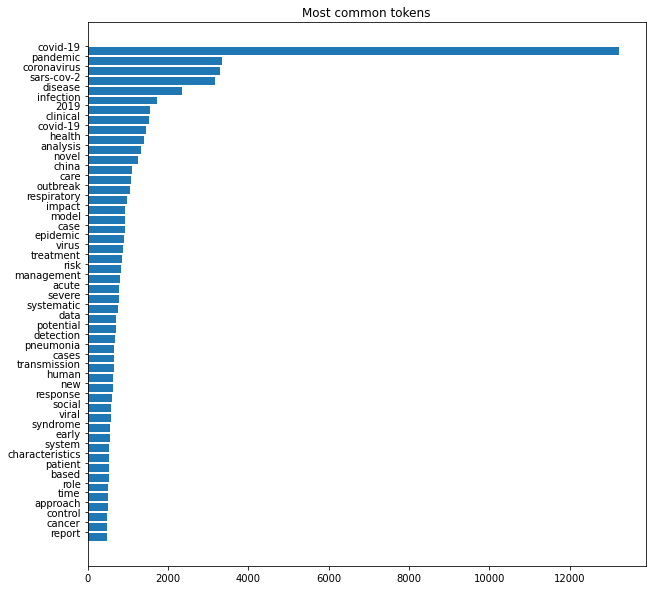

In [134]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata,column='title_processed', title='Most common tokens')

### Abstract results

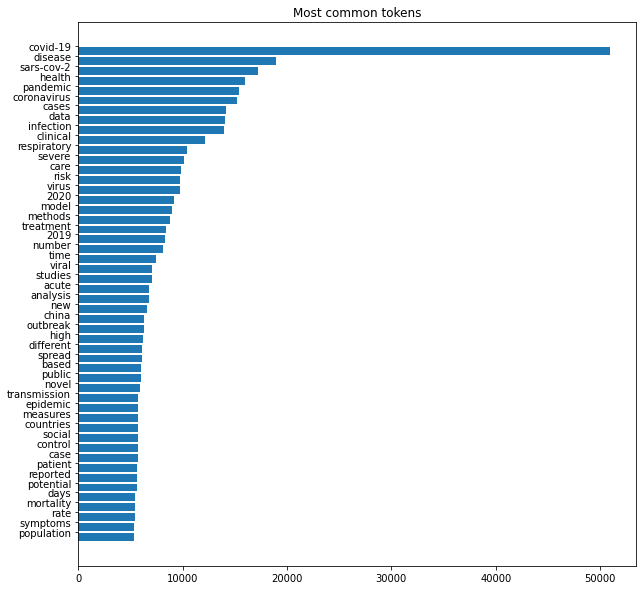

In [135]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata,column='abstract_processed', title='Most common tokens')